# Script to Plot Spatial Trends for EBUS

In [3]:
import numpy as np
import pandas as pd 
import xarray as xr
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import math
import warnings 
warnings.simplefilter('ignore') 
import seaborn as sns
import glob
import statsmodels.api as sm

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from calendar import month_abbr
from matplotlib.ticker import StrMethodFormatter
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker


In [4]:
# #Fix seasons for Southern Hemisphere EBUS (Benguela and Humboldt)
# short_name = 'Beng'

# ds = xr.open_dataset('/Users/administrator/Documents/GitHub/ebus_upwelling_footprint/data/'+short_name+'_ExtendedSubregions_Trend.nc')
# ds.close()

# df = ds.to_dataframe().reset_index()

# df['new_season'] = np.nan
# df.loc[df['season'] == 'fall', 'new_season'] = 'spring'
# df.loc[df['season'] == 'winter', 'new_season'] = 'summer'
# df.loc[df['season'] == 'spring', 'new_season'] = 'fall'
# df.loc[df['season'] == 'summer', 'new_season'] = 'winter'

# ds = df.drop('season', axis = 1).rename({'new_season':'season'}, axis = 1).set_index(['season', 'lat', 'lon']).to_xarray()
# ds.to_netcdf('/Users/administrator/Documents/GitHub/ebus_upwelling_footprint/data/'+short_name+'_ExtendedSubregions_Trend_Corrected.nc')


In [6]:
#read in spatial trends data
short_name = 'Iber'
long_name = 'Iberian'

ds = xr.open_dataset('/Users/administrator/Documents/GitHub/ebus_upwelling_footprint/data/'+short_name+'_ExtendedSubregions_Trend.nc')
ds.close()

#create a mask based on the p-value
ds['sig_mask'] = xr.where(ds['p-value'] < 0.05, 1, np.nan)

#use mask to select out significant areas
ds['trend_sig'] = ds['trend'] * ds['sig_mask']

#add basemap
ds['basemap'] = xr.where(~np.isnan(ds['trend']), 1, np.nan)
ds

<xarray.Dataset>
Dimensions:    (season: 4, lat: 2842, lon: 1989)
Coordinates:
  * season     (season) object 'fall' 'spring' 'summer' 'winter'
  * lat        (lat) float64 14.99 15.0 15.01 15.02 ... 43.37 43.38 43.39 43.4
  * lon        (lon) float64 -25.8 -25.79 -25.78 -25.77 ... -5.94 -5.93 -5.92
Data variables:
    trend      (lat, lon, season) float64 nan nan nan nan ... nan nan nan nan
    p-value    (lat, lon, season) float64 nan nan nan nan ... nan nan nan nan
    sig_mask   (lat, lon, season) float64 nan nan nan nan ... nan nan nan nan
    trend_sig  (lat, lon, season) float64 nan nan nan nan ... nan nan nan nan
    basemap    (lat, lon, season) float64 nan nan nan nan ... nan nan nan nan

### Just Significant Areas Colored

In [87]:
###Map with just significant areas
#select out coordinates based on EBUS
cali_lats = np.array([[28.5,34.5],[34.5,40.4],[40.4,46]]) 
cali_lons = np.array([[-124, -113],[-128, -120], [-129, -123]])
hum_lats = np.array([[-42,-28],[-28,-17],[-17,-10]]) 
hum_lons = np.array([[-79,-69],[-76,-69],[-81,-72]]) 
iber_lats = np.array([[15,21.33],[21.33,30],[37, 43.39]]) 
iber_lons = np.array([[-21,-16],[-21,-9],[-14,-7]]) 
beng_lats = np.array([[-34.8,-28.63],[-28.63, -22],[-22,-15]]) 
beng_lons = np.array([[13, 20],[10, 17],[8, 15]])


#extract the minimum and maximum latitudes and longitudes from all the masks
max_lat = np.nanmax([np.nanmax(ds.lat)])
min_lat = np.nanmin([np.nanmin(ds.lat)])

max_lon = np.nanmax([np.nanmax(ds.lon)])
min_lon = np.nanmin([np.nanmin(ds.lon)])

latr = [min_lat, max_lat]
lonr = [min_lon, max_lon]

#create a region variable with a margin
margin = 1
region = np.array([[latr[0]-margin,latr[1]+margin],[lonr[0]-margin,lonr[1]+margin]]) 
region_raw = np.array([[latr[0],latr[1]],[lonr[0],lonr[1]]]) 

#add state outlines
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

#create and set the figure context
fig, axs = plt.subplots(figsize=(16,10), dpi = 150, nrows=1,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()}) 

axs = axs.ravel()

high_low = np.max([np.abs(ds.min().trend_sig.values), ds.max().trend_sig.values])

for i in range(4):
    axs[i].coastlines(resolution='50m',linewidth=2,color='black', zorder = 1) 
    axs[i].add_feature(cfeature.LAND, color='grey', alpha=0.3)
    axs[i].add_feature(cfeature.BORDERS, color = 'dimgrey', linewidth = 2, zorder = 0)
    
    axs[i].set_xticks([*np.arange(-180,180,5)], crs=ccrs.PlateCarree()) 
    axs[i].xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    #axs[i].set_xlabel('Longitude', fontsize = 18)
    
    if i in [0]:
        axs[i].set_yticks(np.round([*np.arange(np.floor(region_raw[0,0])+1,region_raw[0,1]+1,6)],1), crs=ccrs.PlateCarree()) 
        axs[i].yaxis.set_major_formatter(LatitudeFormatter())
        #axs[i].set_ylabel('Latitude', fontsize = 18)
        
    axs[i].set_extent([region[1,0],region[1,1],region[0,0],region[0,1]],crs=ccrs.PlateCarree()) 
    #ax.gridlines(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    lats_combined = [cali_lats, hum_lats, iber_lats, beng_lats]
    lons_combined = [cali_lons, hum_lons, iber_lons, beng_lons]
    
    if i == 0:
        ds.sel(season = 'winter').drop(['season']).trend_sig.plot(cmap = 'seismic', add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])
        axs[i].set_title('Humboldt - Winter')
    elif i == 1:
        ds.sel(season = 'spring').drop(['season']).trend_sig.plot(cmap = 'seismic', add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])
        axs[i].set_title('Humboldt - Spring')
    elif i == 2:
        ds.sel(season = 'summer').drop(['season']).trend_sig.plot(cmap = 'seismic', add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])
        axs[i].set_title('Humboldt - Summer') 
    else: 
        cs = ds.sel(season = 'fall').drop(['season']).trend_sig.plot(cmap = 'seismic', add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])#, cbar_kwargs = {'label':'Trend', 'pad':0.03, 'shrink':0.5})
        #x, y, width, height
        cb_ax = fig.add_axes([1.0,.17,.0175, .66])
        #fig.colorbar(im,orientation='vertical',cax=cb_ax)
        plt.colorbar(cs, ax = axs[i], cax = cb_ax, label = 'Trend')
        axs[i].set_title('Humboldt - Fall')
    
            
    for ds_lats, ds_lons in zip(lats_combined, lons_combined):
        for j in range(len(ds_lats)):
            rect2 = patches.Rectangle((ds_lons[j][0], ds_lats[j][0]), (ds_lons[j][1]-ds_lons[j][0]), (ds_lats[j][1]-ds_lats[j][0]), linewidth=1, edgecolor='k', facecolor='none', zorder = 3)
            axs[i].add_patch(rect2)

    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    
plt.tight_layout()
plt.savefig('./figures/Test_SpatialTrends/Humboldt_Spatial_Trends_JustSignificant.jpg', facecolor='white', bbox_inches = 'tight', dpi = 300)
plt.show()


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x1780244c0> (for post_execute):


KeyboardInterrupt: 

### Significant Areas Colored with Light Region Mask

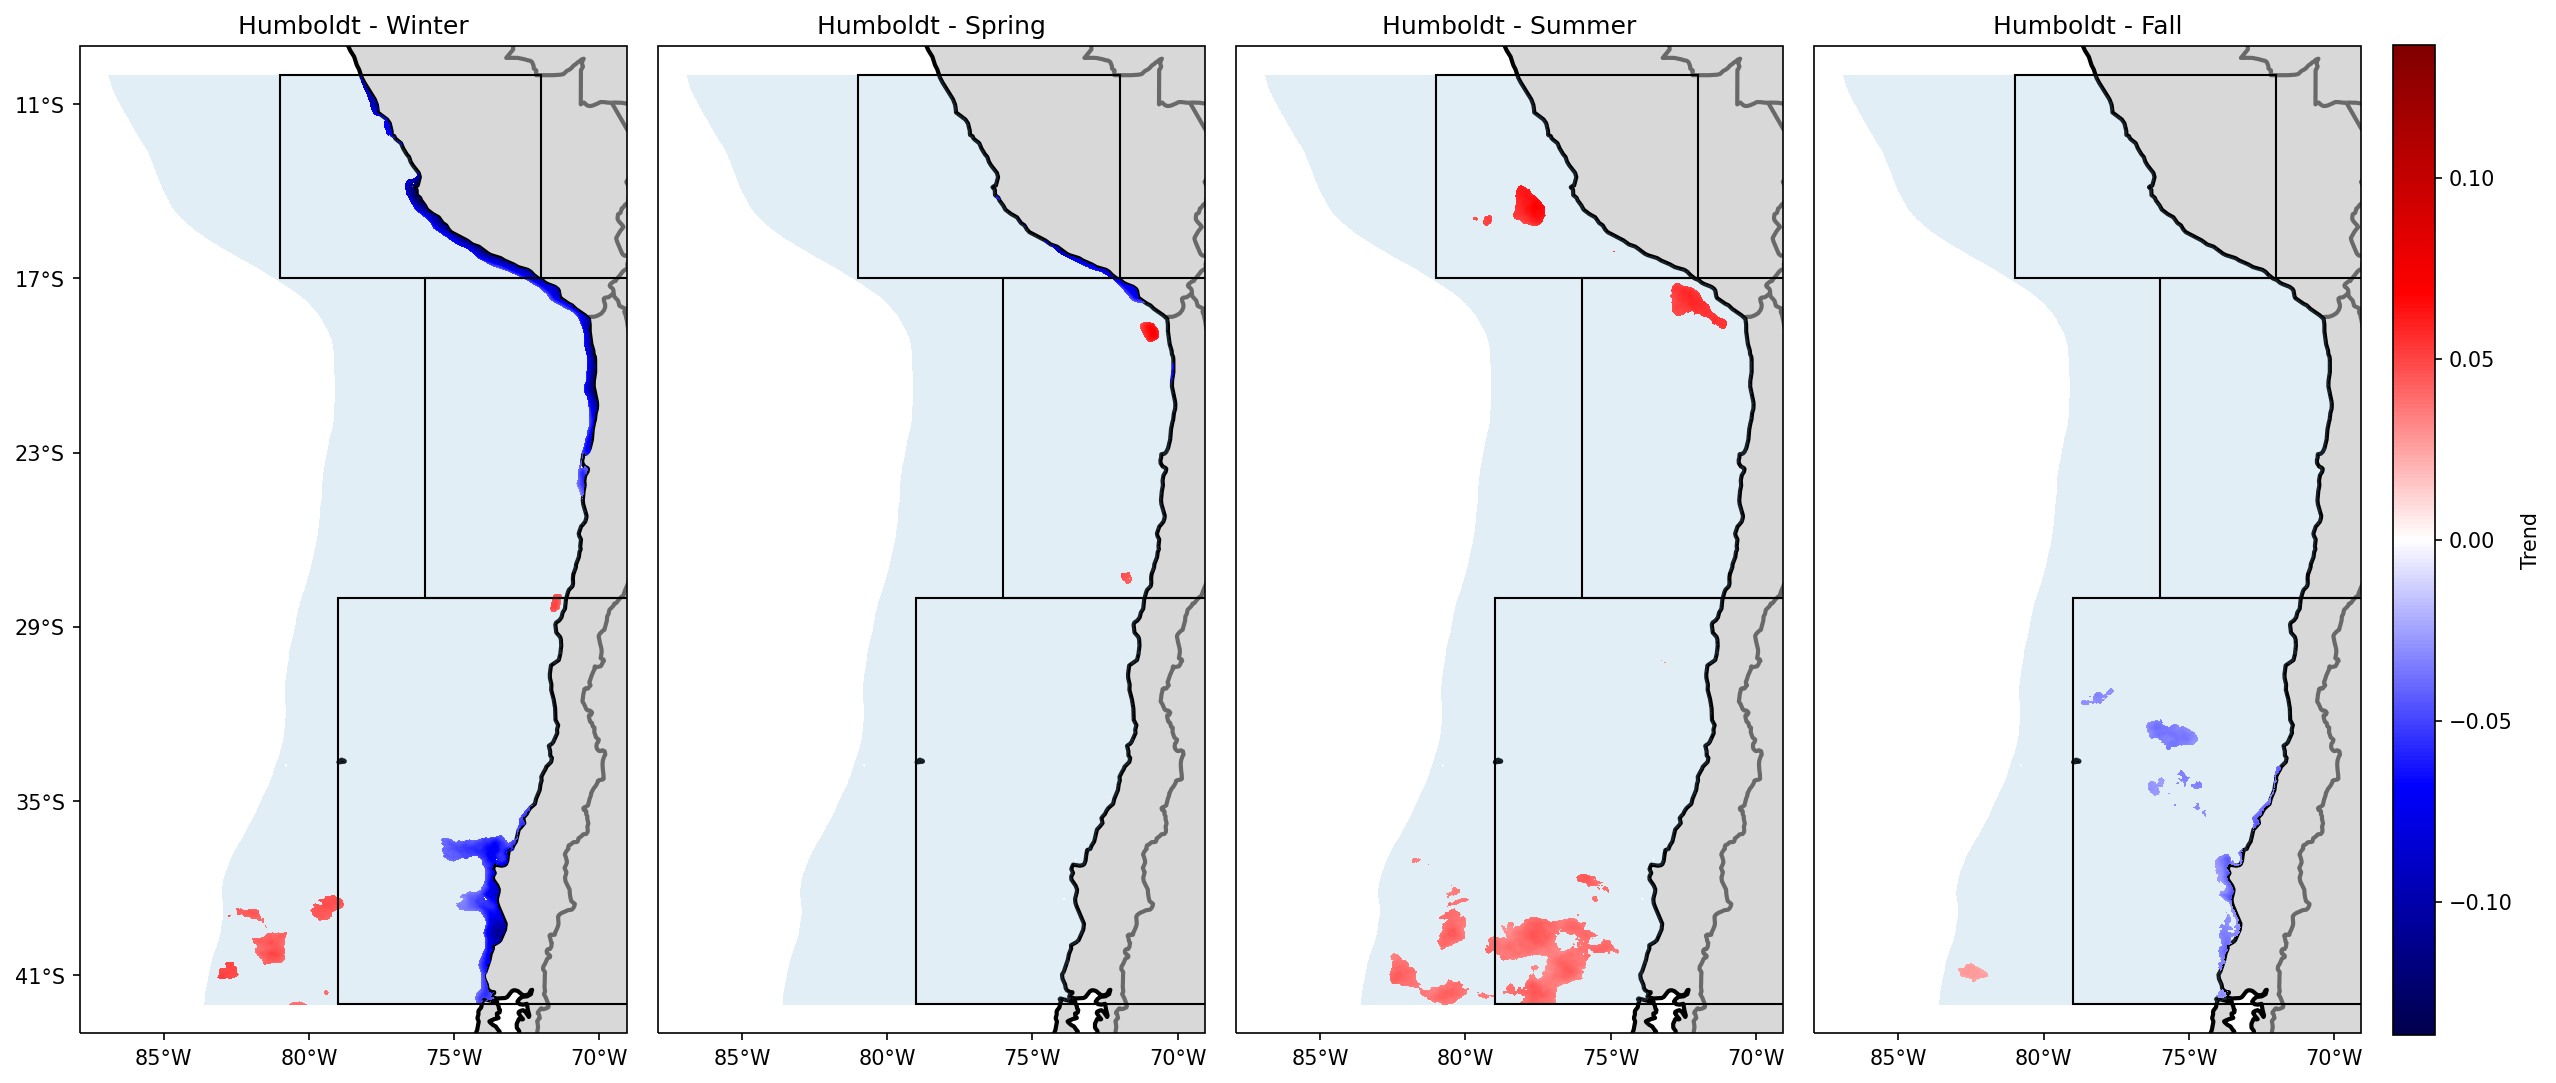

In [47]:
###Map with just significant areas with light colroed mask
#select out coordinates based on EBUS
cali_lats = np.array([[28.5,34.5],[34.5,40.4],[40.4,46]]) 
cali_lons = np.array([[-124, -113],[-128, -120], [-129, -123]])
hum_lats = np.array([[-42,-28],[-28,-17],[-17,-10]]) 
hum_lons = np.array([[-79,-69],[-76,-69],[-81,-72]]) 
iber_lats = np.array([[15,21.33],[21.33,30],[37, 43.39]]) 
iber_lons = np.array([[-21,-16],[-21,-9],[-14,-7]]) 
beng_lats = np.array([[-34.8,-28.63],[-28.63, -22],[-22,-15]]) 
beng_lons = np.array([[13, 20],[10, 17],[8, 15]])


#extract the minimum and maximum latitudes and longitudes from all the masks
max_lat = np.nanmax([np.nanmax(ds.lat)])
min_lat = np.nanmin([np.nanmin(ds.lat)])

max_lon = np.nanmax([np.nanmax(ds.lon)])
min_lon = np.nanmin([np.nanmin(ds.lon)])

latr = [min_lat, max_lat]
lonr = [min_lon, max_lon]

#create a region variable with a margin
margin = 1
region = np.array([[latr[0]-margin,latr[1]+margin],[lonr[0]-margin,lonr[1]+margin]]) 
region_raw = np.array([[latr[0],latr[1]],[lonr[0],lonr[1]]]) 

#add state outlines
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

#create and set the figure context
fig, axs = plt.subplots(figsize=(16,10), dpi = 150, nrows=1,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()}) 

axs = axs.ravel()

high_low = np.max([np.abs(ds.min().trend_sig.values), ds.max().trend_sig.values])

for i in range(4):
    axs[i].coastlines(resolution='50m',linewidth=2,color='black', zorder = 1) 
    axs[i].add_feature(cfeature.LAND, color='grey', alpha=0.3)
    axs[i].add_feature(cfeature.BORDERS, color = 'dimgrey', linewidth = 2, zorder = 0)
    
    axs[i].set_xticks([*np.arange(-180,180,5)], crs=ccrs.PlateCarree()) 
    axs[i].xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    #axs[i].set_xlabel('Longitude', fontsize = 18)
    
    if i in [0]:
        axs[i].set_yticks(np.round([*np.arange(np.floor(region_raw[0,0])+1,region_raw[0,1]+1,6)],1), crs=ccrs.PlateCarree()) 
        axs[i].yaxis.set_major_formatter(LatitudeFormatter())
        #axs[i].set_ylabel('Latitude', fontsize = 18)
        
    axs[i].set_extent([region[1,0],region[1,1],region[0,0],region[0,1]],crs=ccrs.PlateCarree()) 
    #ax.gridlines(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    lats_combined = [cali_lats, hum_lats, iber_lats, beng_lats]
    lons_combined = [cali_lons, hum_lons, iber_lons, beng_lons]
    
    ds.isel(season = 1).drop(['season']).basemap.plot(cmap = 'Blues', alpha = 0.2, add_colorbar = False, ax = axs[i])
    
    if i == 0:
        ds.sel(season = 'winter').drop(['season']).trend_sig.plot(cmap = 'seismic', add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])
        axs[i].set_title('Humboldt - Winter')
    elif i == 1:
        ds.sel(season = 'spring').drop(['season']).trend_sig.plot(cmap = 'seismic', add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])
        axs[i].set_title('Humboldt - Spring')
    elif i == 2:
        ds.sel(season = 'summer').drop(['season']).trend_sig.plot(cmap = 'seismic', add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])
        axs[i].set_title('Humboldt - Summer') 
    else: 
        cs = ds.sel(season = 'fall').drop(['season']).trend_sig.plot(cmap = 'seismic', add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])#, cbar_kwargs = {'label':'Trend', 'pad':0.03, 'shrink':0.5})
        #x, y, width, height
        cb_ax = fig.add_axes([1.0,.17,.0175, .66])
        #fig.colorbar(im,orientation='vertical',cax=cb_ax)
        plt.colorbar(cs, ax = axs[i], cax = cb_ax, label = 'Trend')
        axs[i].set_title('Humboldt - Fall')
    
            
    for ds_lats, ds_lons in zip(lats_combined, lons_combined):
        for j in range(len(ds_lats)):
            rect2 = patches.Rectangle((ds_lons[j][0], ds_lats[j][0]), (ds_lons[j][1]-ds_lons[j][0]), (ds_lats[j][1]-ds_lats[j][0]), linewidth=1, edgecolor='k', facecolor='none', zorder = 3)
            axs[i].add_patch(rect2)

    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    
plt.tight_layout()
plt.savefig('./figures/Test_SpatialTrends/Humboldt_Spatial_Trends_SignficantwithMask.jpg', facecolor='white', bbox_inches = 'tight', dpi = 300)
plt.show()


### Script with Significant Areas Darker (Same Colorbar)

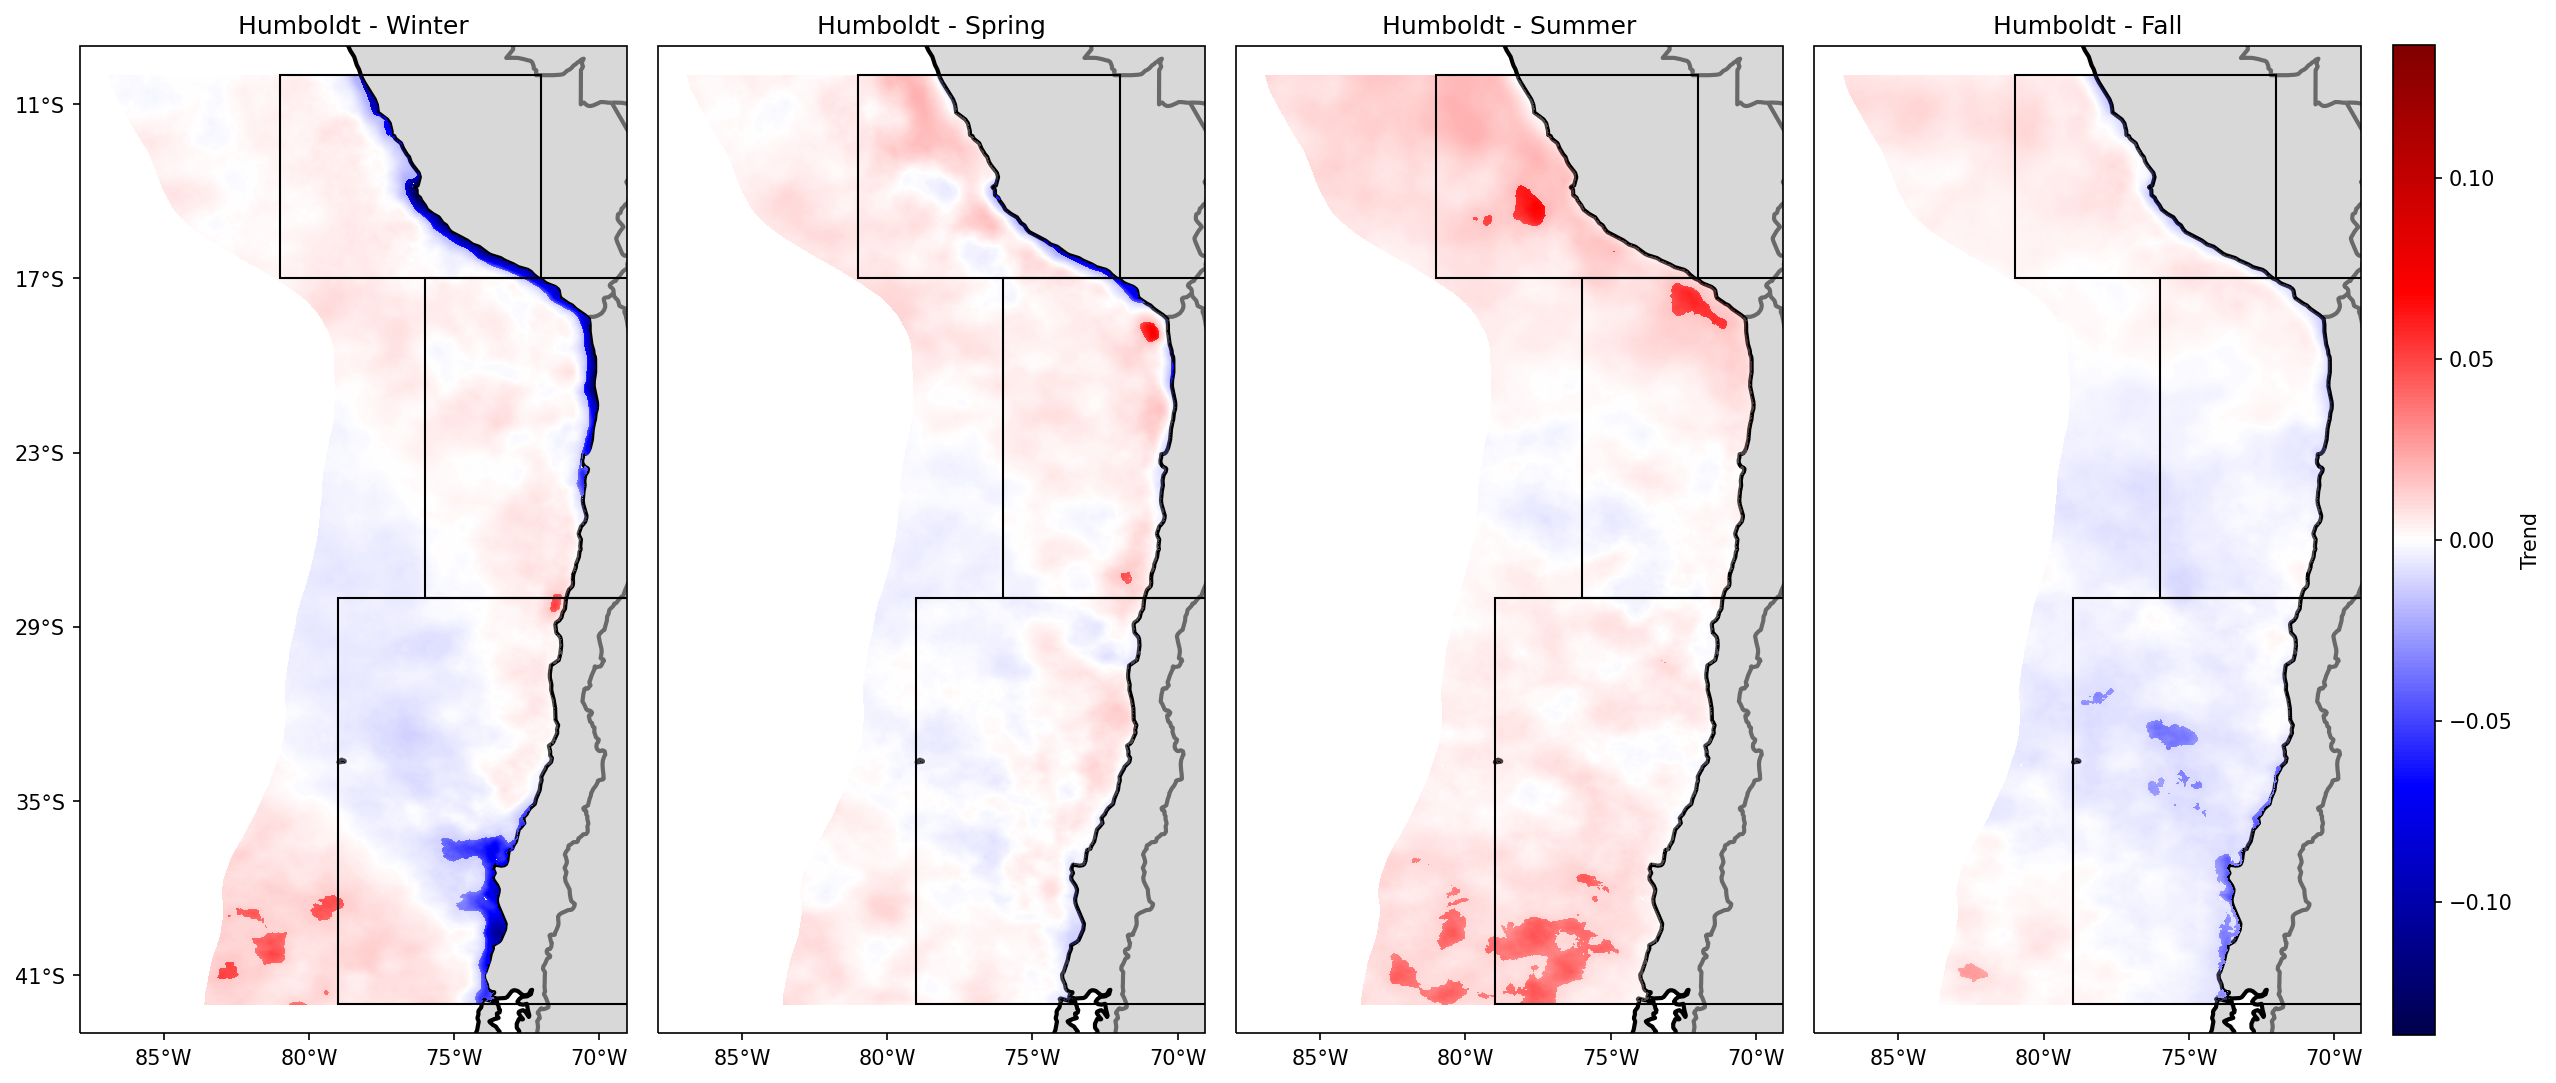

In [50]:
###Map with significant areas darker
#select out coordinates based on EBUS
cali_lats = np.array([[28.5,34.5],[34.5,40.4],[40.4,46]]) 
cali_lons = np.array([[-124, -113],[-128, -120], [-129, -123]])
hum_lats = np.array([[-42,-28],[-28,-17],[-17,-10]]) 
hum_lons = np.array([[-79,-69],[-76,-69],[-81,-72]]) 
iber_lats = np.array([[15,21.33],[21.33,30],[37, 43.39]]) 
iber_lons = np.array([[-21,-16],[-21,-9],[-14,-7]]) 
beng_lats = np.array([[-34.8,-28.63],[-28.63, -22],[-22,-15]]) 
beng_lons = np.array([[13, 20],[10, 17],[8, 15]])


#extract the minimum and maximum latitudes and longitudes from all the masks
max_lat = np.nanmax([np.nanmax(ds.lat)])
min_lat = np.nanmin([np.nanmin(ds.lat)])

max_lon = np.nanmax([np.nanmax(ds.lon)])
min_lon = np.nanmin([np.nanmin(ds.lon)])

latr = [min_lat, max_lat]
lonr = [min_lon, max_lon]

#create a region variable with a margin
margin = 1
region = np.array([[latr[0]-margin,latr[1]+margin],[lonr[0]-margin,lonr[1]+margin]]) 
region_raw = np.array([[latr[0],latr[1]],[lonr[0],lonr[1]]]) 

#add state outlines
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

#create and set the figure context
fig, axs = plt.subplots(figsize=(16,10), dpi = 150, nrows=1,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()}) 

axs = axs.ravel()

high_low = np.max([np.abs(ds.min().trend_sig.values), ds.max().trend_sig.values])

for i in range(4):
    axs[i].coastlines(resolution='50m',linewidth=2,color='black', zorder = 1) 
    axs[i].add_feature(cfeature.LAND, color='grey', alpha=0.3)
    axs[i].add_feature(cfeature.BORDERS, color = 'dimgrey', linewidth = 2, zorder = 0)
    
    axs[i].set_xticks([*np.arange(-180,180,5)], crs=ccrs.PlateCarree()) 
    axs[i].xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    #axs[i].set_xlabel('Longitude', fontsize = 18)
    
    if i in [0]:
        axs[i].set_yticks(np.round([*np.arange(np.floor(region_raw[0,0])+1,region_raw[0,1]+1,6)],1), crs=ccrs.PlateCarree()) 
        axs[i].yaxis.set_major_formatter(LatitudeFormatter())
        #axs[i].set_ylabel('Latitude', fontsize = 18)
        
    axs[i].set_extent([region[1,0],region[1,1],region[0,0],region[0,1]],crs=ccrs.PlateCarree()) 
    #ax.gridlines(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    lats_combined = [cali_lats, hum_lats, iber_lats, beng_lats]
    lons_combined = [cali_lons, hum_lons, iber_lons, beng_lons]
    
    
    if i == 0:
        ds.sel(season = 'winter').drop(['season']).trend.plot(cmap = 'seismic', alpha = 0.3, add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])
        ds.sel(season = 'winter').drop(['season']).trend_sig.plot(cmap = 'seismic', add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])
        axs[i].set_title('Humboldt - Winter')
    elif i == 1:
        ds.sel(season = 'spring').drop(['season']).trend.plot(cmap = 'seismic', alpha = 0.3, add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])
        ds.sel(season = 'spring').drop(['season']).trend_sig.plot(cmap = 'seismic', add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])
        axs[i].set_title('Humboldt - Spring')
    elif i == 2:
        ds.sel(season = 'summer').drop(['season']).trend.plot(cmap = 'seismic', alpha = 0.3, add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])
        ds.sel(season = 'summer').drop(['season']).trend_sig.plot(cmap = 'seismic', add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])
        axs[i].set_title('Humboldt - Summer') 
    else: 
        cs = ds.sel(season = 'fall').drop(['season']).trend.plot(cmap = 'seismic', alpha = 0.3, add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])#, cbar_kwargs = {'label':'Trend', 'pad':0.03, 'shrink':0.5})
        cs = ds.sel(season = 'fall').drop(['season']).trend_sig.plot(cmap = 'seismic', add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])#, cbar_kwargs = {'label':'Trend', 'pad':0.03, 'shrink':0.5})
        #x, y, width, height
        cb_ax = fig.add_axes([1.0,.17,.0175, .66])
        #fig.colorbar(im,orientation='vertical',cax=cb_ax)
        plt.colorbar(cs, ax = axs[i], cax = cb_ax, label = 'Trend')
        axs[i].set_title('Humboldt - Fall')
    
            
    for ds_lats, ds_lons in zip(lats_combined, lons_combined):
        for j in range(len(ds_lats)):
            rect2 = patches.Rectangle((ds_lons[j][0], ds_lats[j][0]), (ds_lons[j][1]-ds_lons[j][0]), (ds_lats[j][1]-ds_lats[j][0]), linewidth=1, edgecolor='k', facecolor='none', zorder = 3)
            axs[i].add_patch(rect2)

    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    
plt.tight_layout()
plt.savefig('./figures/Test_SpatialTrends/Humboldt_Spatial_Trends_LightMask.jpg', facecolor='white', bbox_inches = 'tight', dpi = 300)
plt.show()


### Script with Significant Areas Darker (Different Colorbar)

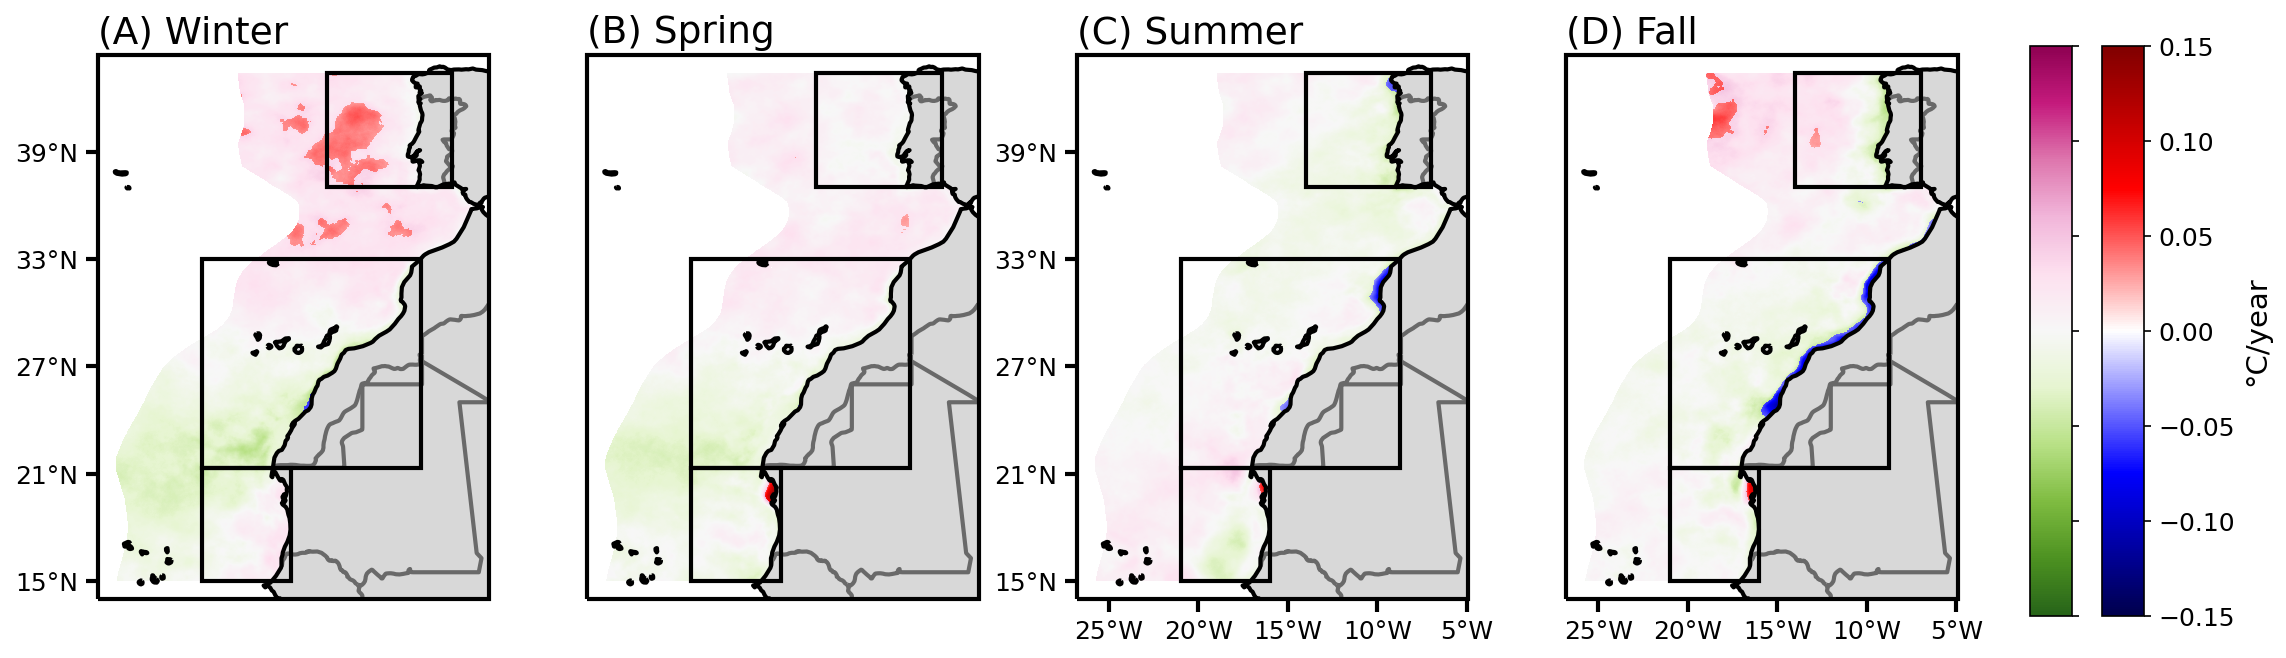

In [22]:
###Map with significant areas colored differently
#select out coordinates based on EBUS
cali_lats = np.array([[28.5,34.5],[34.5,40.4],[40.4,46]]) 
cali_lons = np.array([[-124, -113],[-128, -120], [-129, -123]])
hum_lats = np.array([[-42,-28],[-28,-17],[-17,-10]]) 
hum_lons = np.array([[-79,-69],[-76,-69],[-81,-72]]) 
iber_lats = np.array([[15,21.33],[21.33,33],[37, 43.39]]) 
iber_lons = np.array([[-21,-16],[-21,-8.75],[-14,-7]]) 
beng_lats = np.array([[-34.8,-28.63],[-28.63, -22],[-22,-15]]) 
beng_lons = np.array([[13, 20],[10, 17],[8, 15]])


#extract the minimum and maximum latitudes and longitudes from all the masks
max_lat = np.nanmax([np.nanmax(ds.lat)])
min_lat = np.nanmin([np.nanmin(ds.lat)])

max_lon = np.nanmax([np.nanmax(ds.lon)])
min_lon = np.nanmin([np.nanmin(ds.lon)])

latr = [min_lat, max_lat]
lonr = [min_lon, max_lon]

#create a region variable with a margin
margin = 1
region = np.array([[latr[0]-margin,latr[1]+margin],[lonr[0]-margin,lonr[1]+margin]]) 
region_raw = np.array([[latr[0],latr[1]],[lonr[0],lonr[1]]]) 

#add state outlines
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

#create and set the figure context
fig, axs = plt.subplots(figsize=(16,10), dpi = 150, nrows=1,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()}) 

axs = axs.ravel()

# high_low = np.max([np.abs(ds.min().trend_sig.values), ds.max().trend_sig.values])
high_low = 0.15

for i in range(4):
    axs[i].coastlines(resolution='50m',linewidth=2,color='black', zorder = 1) 
    axs[i].add_feature(cfeature.LAND, color='grey', alpha=0.3)
    axs[i].add_feature(cfeature.BORDERS, color = 'dimgrey', linewidth = 2, zorder = 0)
    
    if i in [2, 3]:
        axs[i].set_xticks([*np.arange(-180,180,5)], crs=ccrs.PlateCarree()) 
        axs[i].xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
        #axs[i].set_xlabel('Longitude', fontsize = 18)
    
    if i in [0, 2]:
        axs[i].set_yticks(np.round([*np.arange(np.floor(region_raw[0,0])+1,region_raw[0,1]+1,6)],1), crs=ccrs.PlateCarree()) 
        axs[i].yaxis.set_major_formatter(LatitudeFormatter())
        #axs[i].set_ylabel('Latitude', fontsize = 18)
        
    axs[i].set_extent([region[1,0],region[1,1],region[0,0],region[0,1]],crs=ccrs.PlateCarree()) 
    #ax.gridlines(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    lats_combined = [cali_lats, hum_lats, iber_lats, beng_lats]
    lons_combined = [cali_lons, hum_lons, iber_lons, beng_lons]
    
    
    if i == 0:
        ds.sel(season = 'winter').drop(['season']).trend.plot(cmap = 'PiYG_r', alpha = 1, add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])
        ds.sel(season = 'winter').drop(['season']).trend_sig.plot(cmap = 'seismic', add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])
        axs[i].set_title('(A) Winter', fontsize = 18, loc = 'left')
    elif i == 1:
        ds.sel(season = 'spring').drop(['season']).trend.plot(cmap = 'PiYG_r', alpha = 1, add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])
        ds.sel(season = 'spring').drop(['season']).trend_sig.plot(cmap = 'seismic', add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])
        axs[i].set_title('(B) Spring', fontsize = 18, loc = 'left')
    elif i == 2:
        ds.sel(season = 'summer').drop(['season']).trend.plot(cmap = 'PiYG_r', alpha = 1, add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])
        ds.sel(season = 'summer').drop(['season']).trend_sig.plot(cmap = 'seismic', add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])
        axs[i].set_title('(C) Summer', fontsize = 18, loc = 'left') 
    else: 
        CS = ds.sel(season = 'fall').drop(['season']).trend.plot(cmap = 'PiYG_r', alpha = 1, add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])#, cbar_kwargs = {'label':'Trend', 'pad':0.03, 'shrink':0.5})
        if short_name == 'Hum':
            cb_ax = fig.add_axes([1.0,.17,.0175, .66])
        elif short_name == 'Cali':
            cb_ax = fig.add_axes([1.0,.345,.0175, .31])
        elif short_name == 'Beng':
            cb_ax = fig.add_axes([1.0,.29,.0175, .42])
        else: #short_name == 'Iber':
            cb_ax = fig.add_axes([0.93,.31,.0175, .38])
            
            
        #fig.colorbar(im,orientation='vertical',cax=cb_ax)
        cbar = plt.colorbar(CS, ax = axs[i], cax = cb_ax, label = '', format = matplotlib.ticker.FuncFormatter(lambda x, pos: ''))
        #cbar.set_ticks([])
        
        cs = ds.sel(season = 'fall').drop(['season']).trend_sig.plot(cmap = 'seismic', add_colorbar = False, vmin = high_low*-1, vmax = high_low, ax = axs[i])#, cbar_kwargs = {'label':'Trend', 'pad':0.03, 'shrink':0.5})
        #x, y, width, height
        if short_name == 'Hum':
            cb_ax = fig.add_axes([1.03,.17,.0175, .66])
        elif short_name == 'Cali':
            cb_ax = fig.add_axes([1.03,.345,.0175, .31])
        elif short_name == 'Beng':
            cb_ax = fig.add_axes([1.03,.29,.0175, .42])
        else: #short_name == 'Iber':
            cb_ax = fig.add_axes([0.96,.31,.0175, .38])

        #fig.colorbar(im,orientation='vertical',cax=cb_ax)
        cb = plt.colorbar(cs, ax = axs[i], cax = cb_ax)
        cb.set_label(label = '°C/year', size = 14)
        cb.ax.tick_params(labelsize=12)
        axs[i].set_title('(D) Fall', fontsize = 18, loc = 'left')
    
            
    for ds_lats, ds_lons in zip(lats_combined, lons_combined):
        for j in range(len(ds_lats)):
            rect2 = patches.Rectangle((ds_lons[j][0], ds_lats[j][0]), (ds_lons[j][1]-ds_lons[j][0]), (ds_lats[j][1]-ds_lats[j][0]), linewidth=2, edgecolor='k', facecolor='none', zorder = 3)
            axs[i].add_patch(rect2)

    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    [x.set_linewidth(2) for x in axs[i].spines.values()]
    axs[i].tick_params('both', labelsize=12, width = 2, length = 6)

    
plt.tight_layout()
if short_name == 'Iber':
    subplots_adjustjust(wspace=0.25, hspace=None)
plt.savefig('./figures/Test_SpatialTrends/'+long_name+'_Spatial_Trends_DifferentColorMask.jpg', facecolor='white', bbox_inches = 'tight', dpi = 300)
plt.show()


In [85]:
print('Max')
print(ds.groupby('season').max(...).to_dataframe()['trend_sig'].round(4).T, '\n')

print('Median')
print(ds.groupby('season').median(...).to_dataframe()['trend_sig'].round(4).T, '\n')

print('Mean')
print(ds.groupby('season').mean(...).to_dataframe()['trend_sig'].round(4).T, '\n')

print('Min')
print(ds.groupby('season').min(...).to_dataframe()['trend_sig'].round(4).T, '\n')

Max
season
fall      0.1036
spring    0.1399
summer    0.0748
winter    0.0520
Name: trend_sig, dtype: float64 

Median
season
fall     -0.0447
spring    0.0723
summer   -0.0494
winter    0.0376
Name: trend_sig, dtype: float64 

Mean
season
fall     -0.0153
spring    0.0646
summer   -0.0431
winter    0.0361
Name: trend_sig, dtype: float64 

Min
season
fall     -0.1223
spring   -0.0472
summer   -0.0862
winter   -0.0708
Name: trend_sig, dtype: float64 



### Trends for Certain Pixels

In [69]:
temp = ds.where(ds.trend == ds.trend.min(), drop = True).to_dataframe()#.dropna().reset_index().groupby(['lat', 'lon']).size()
temp

,,,trend,p-value,sig_mask,trend_sig,basemap
lat,lon,season,,,,,
42.66,-124.419998,spring,-0.049323,0.1689,NaN,NaN,1.0


In [56]:
high = ds.interp(lat = [37.81001], lon = [-122.54001], method = 'nearest').to_dataframe().reset_index()
high

,season,lat,lon,trend,p-value,sig_mask,trend_sig,basemap
0,fall,33.57,-119.529999,0.106954,0.0032,1.0,0.106954,1.0
1,spring,33.57,-119.529999,0.051508,0.0381,1.0,0.051508,1.0
2,summer,33.57,-119.529999,0.085342,0.0080,1.0,0.085342,1.0
3,winter,33.57,-119.529999,0.059694,0.0494,1.0,0.059694,1.0


In [61]:
all_seasons = ds.interp(lat = [33.580002], lon = [-119.570000], method = 'nearest').to_dataframe().reset_index()
all_seasons

,season,lat,lon,trend,p-value,sig_mask,trend_sig,basemap
0,fall,33.580002,-119.57,0.107890,0.0029,1.0,0.107890,1.0
1,spring,33.580002,-119.57,0.051104,0.0379,1.0,0.051104,1.0
2,summer,33.580002,-119.57,0.085828,0.0084,1.0,0.085828,1.0
3,winter,33.580002,-119.57,0.059480,0.0497,1.0,0.059480,1.0


In [70]:
non_sig = ds.interp(lat = [42.66], lon = [-124.419998], method = 'nearest').to_dataframe().reset_index()
non_sig

,season,lat,lon,trend,p-value,sig_mask,trend_sig,basemap
0,fall,42.66,-124.419998,0.046740,0.0944,NaN,NaN,1.0
1,spring,42.66,-124.419998,-0.049323,0.1689,NaN,NaN,1.0
2,summer,42.66,-124.419998,-0.013213,0.6440,NaN,NaN,1.0
3,winter,42.66,-124.419998,0.006207,0.8585,NaN,NaN,1.0


In [54]:
short_name = 'Cali'
ds = xr.open_dataset('/Users/administrator/Documents/GitHub/ebus_upwelling_footprint/data/'+short_name+'_ExtendedSubregions_All.nc')

#calculate seasonal index starting in december
ds_season = ds.resample(time = '1QS-DEC').mean()
ds_season

<xarray.Dataset>
Dimensions:       (time: 80, lat: 1751, lon: 2024)
Coordinates:
  * time          (time) datetime64[ns] 2002-06-01 2002-09-01 ... 2022-03-01
  * lat           (lat) float32 28.5 28.51 28.52 28.53 ... 45.98 45.99 46.0
  * lon           (lon) float32 -134.1 -134.1 -134.1 ... -113.9 -113.9 -113.9
Data variables:
    analysed_sst  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

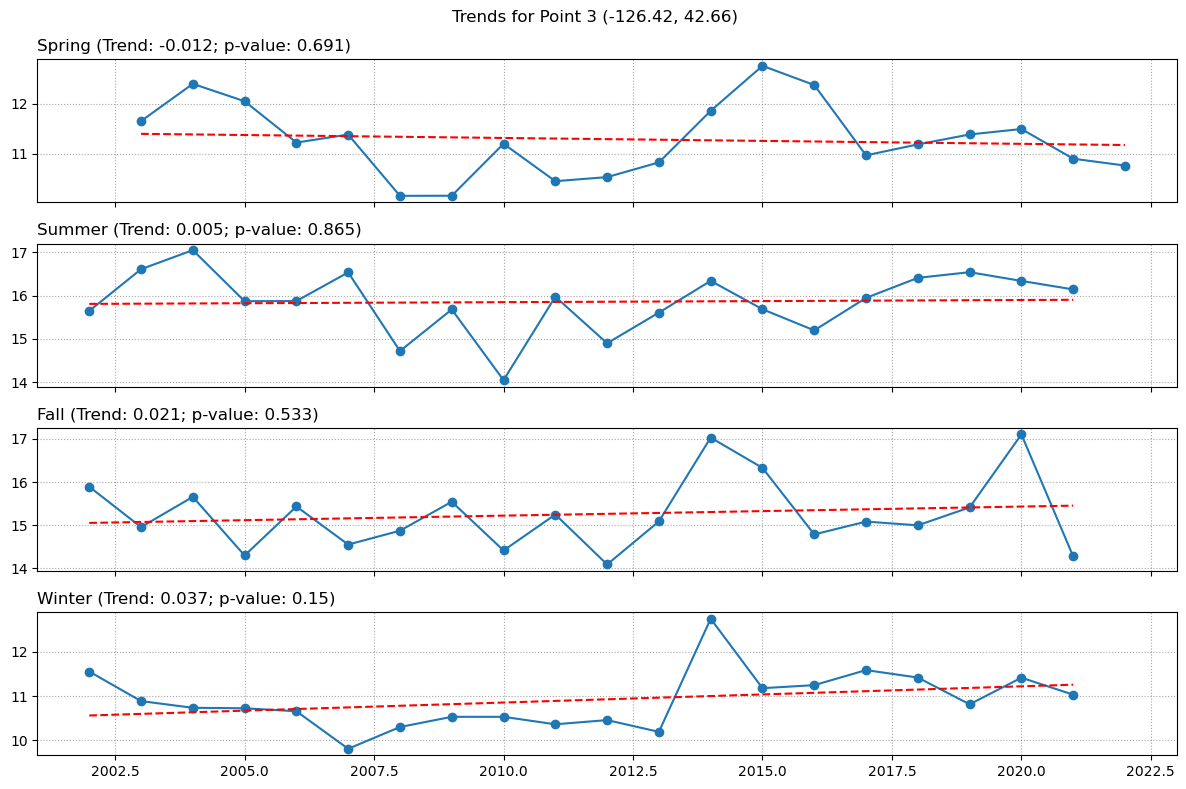

In [58]:
# coords = [37.81001, -122.54001]
# coords = [33.580002, -119.570000]
# coords = [42.66, -124.419998]

# coords = [31.58, -118.5]
# coords = [35.25, -126.5]
coords = [42.66, -126.419]

ds_season_sel = ds_season.interp(lat = coords[0], lon = coords[1], method = 'nearest')

df = ds_season_sel.to_dataframe()
df = df.dropna().reset_index()
df['year'] = df['time'].dt.year

fig, axs = plt.subplots(ncols = 1, nrows = 4, figsize = (12, 8), sharex = True, sharey = False)

for i, j, season in zip([3, 6, 9, 12], [*range(4)], ['spring', 'summer', 'fall', 'winter']):
    #select out temporary data
    df_temp = df[df['time'].dt.month == i]
    
    #select out x and y
    X = df_temp['year']
    Y = df_temp['analysed_sst']
    
    #add a condstant for the regression
    X = sm.add_constant(X) 
    
    #run the model
    model = sm.OLS(Y, X, missing = 'drop').fit()

    #return the trend and p-value
    trend = np.around(model.params[1], 6)
    p_val = np.around(model.pvalues[1], 4)
    
    ypred = model.predict(X)
    
    
    axs[j].plot(df_temp['year'], df_temp['analysed_sst'], marker = 'o')
    
    if p_val > 0.05:
        axs[j].plot(df_temp['year'], ypred, c = 'red', linestyle = 'dashed')
    else: 
        axs[j].plot(df_temp['year'], ypred, c = 'red', linestyle = 'solid')
    axs[j].set_title(season.title() + ' (Trend: ' + str(np.around(trend, 3)) + '; p-value: ' + str(np.around(p_val, 3)) + ')', loc = 'left')
    axs[j].grid(linestyle = 'dotted', color = 'grey', alpha = 0.7)
    # axs[j].text(2002, 19, u"Trend: {:0.3f}".format(trend), horizontalalignment = 'left')
    # axs[j].text(2002, 18.2, u"p-value: {:0.3f}".format(p_val), horizontalalignment = 'left')

    
plt.suptitle('Trends for Point 3 (' + str(np.around(coords[1], 2)) + ', ' + str(np.around(coords[0], 2)) + ')')
plt.tight_layout()

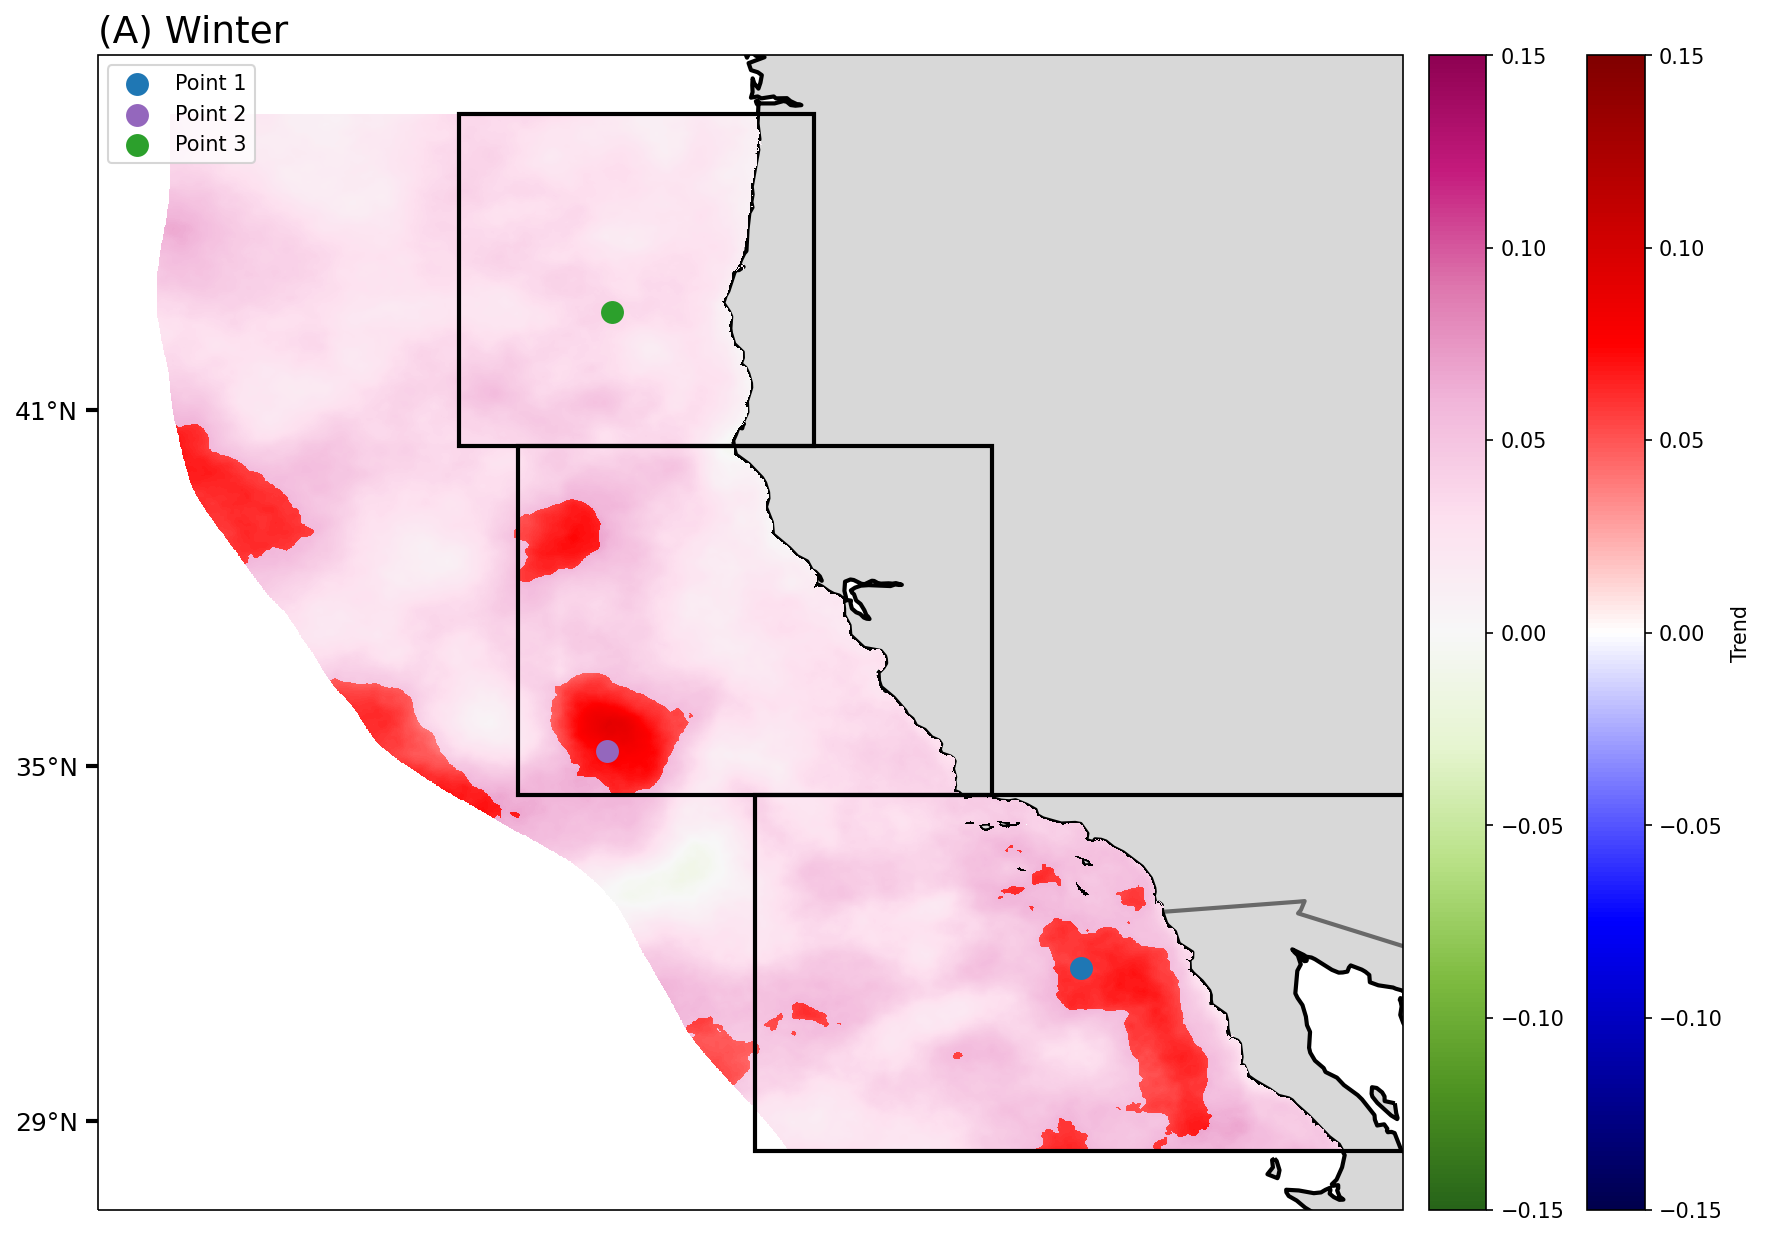

In [53]:
###Map with significant areas colored differently
#select out coordinates based on EBUS
cali_lats = np.array([[28.5,34.5],[34.5,40.4],[40.4,46]]) 
cali_lons = np.array([[-124, -113],[-128, -120], [-129, -123]])
hum_lats = np.array([[-42,-28],[-28,-17],[-17,-10]]) 
hum_lons = np.array([[-79,-69],[-76,-69],[-81,-72]]) 
iber_lats = np.array([[15,21.33],[21.33,30],[37, 43.39]]) 
iber_lons = np.array([[-21,-16],[-21,-9],[-14,-7]]) 
beng_lats = np.array([[-34.8,-28.63],[-28.63, -22],[-22,-15]]) 
beng_lons = np.array([[13, 20],[10, 17],[8, 15]])


#extract the minimum and maximum latitudes and longitudes from all the masks
max_lat = np.nanmax([np.nanmax(ds.lat)])
min_lat = np.nanmin([np.nanmin(ds.lat)])

max_lon = np.nanmax([np.nanmax(ds.lon)])
min_lon = np.nanmin([np.nanmin(ds.lon)])

latr = [min_lat, max_lat]
lonr = [min_lon, max_lon]

#create a region variable with a margin
margin = 1
region = np.array([[latr[0]-margin,latr[1]+margin],[lonr[0]-margin,lonr[1]+margin]]) 
region_raw = np.array([[latr[0],latr[1]],[lonr[0],lonr[1]]]) 

#add state outlines
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

#create and set the figure context
fig, axs = plt.subplots(figsize=(16,10), dpi = 150, nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()}) 

# axs = axs.ravel()

# high_low = np.max([np.abs(ds.min().trend_sig.values), ds.max().trend_sig.values])
high_low = 0.15

i = 0

axs.coastlines(resolution='50m',linewidth=2,color='black', zorder = 1) 
axs.add_feature(cfeature.LAND, color='grey', alpha=0.3)
axs.add_feature(cfeature.BORDERS, color = 'dimgrey', linewidth = 2, zorder = 0)

if i in [2, 3]:
    axs.set_xticks([*np.arange(-180,180,5)], crs=ccrs.PlateCarree()) 
    axs.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    #axs[i].set_xlabel('Longitude', fontsize = 18)

if i in [0, 2]:
    axs.set_yticks(np.round([*np.arange(np.floor(region_raw[0,0])+1,region_raw[0,1]+1,6)],1), crs=ccrs.PlateCarree()) 
    axs.yaxis.set_major_formatter(LatitudeFormatter())
    #axs[i].set_ylabel('Latitude', fontsize = 18)

axs.set_extent([region[1,0],region[1,1],region[0,0],region[0,1]],crs=ccrs.PlateCarree()) 
#ax.gridlines(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

lats_combined = [cali_lats, hum_lats, iber_lats, beng_lats]
lons_combined = [cali_lons, hum_lons, iber_lons, beng_lons]


if i == 0:
    ds.sel(season = 'winter').drop(['season']).trend.plot(cmap = 'PiYG_r', alpha = 1, add_colorbar = True, vmin = high_low*-1, vmax = high_low, ax = axs, cbar_kwargs={'label':'', 'pad':-0.25})
    ds.sel(season = 'winter').drop(['season']).trend_sig.plot(cmap = 'seismic', add_colorbar = True, vmin = high_low*-1, vmax = high_low, ax = axs, cbar_kwargs={'label': 'Trend', 'pad':0.09})
    axs.set_title('(A) Winter', fontsize = 18, loc = 'left')
    
for ds_lats, ds_lons in zip(lats_combined, lons_combined):
    for j in range(len(ds_lats)):
        rect2 = patches.Rectangle((ds_lons[j][0], ds_lats[j][0]), (ds_lons[j][1]-ds_lons[j][0]), (ds_lats[j][1]-ds_lats[j][0]), linewidth=2, edgecolor='k', facecolor='none', zorder = 3)
        axs.add_patch(rect2)

axs.set_xlabel('')
axs.set_ylabel('')
axs.tick_params('both', labelsize=12, width = 2, length = 6)


# plt.scatter(-122.54, 37.81, label = 'Point 1', c = 'tab:red', s = 100)
# plt.scatter(-119.57, 33.58, label = 'Point 2', c = 'tab:blue', s = 100)
# plt.scatter(-124.419, 42.66, label = 'Point 3', c = 'tab:green', s = 100)
plt.scatter(-118.5, 31.58, label = 'Point 1', c = 'tab:blue', s = 100)
plt.scatter(-126.5, 35.25, label = 'Point 2', c = 'tab:purple', s = 100)
plt.scatter(-126.419, 42.66, label = 'Point 3', c = 'tab:green', s = 100)

plt.legend(loc = 'upper left')
# plt.tight_layout()
# # plt.savefig('./figures/Test_SpatialTrends/'+long_name+'_Spatial_Trends_DifferentColorMask.jpg', facecolor='white', bbox_inches = 'tight', dpi = 300)
# plt.show()
